# Import

In [1]:
import json
import psycopg2
import time
import pandas as pd
from datetime import datetime
import numpy as np
import math
import pickle
import warnings
import os
import pandas.io.sql as sqlio
# from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to DataBase

In [2]:
conn = psycopg2.connect(
    host='hp-dev-db-12sep.cgitnjqny0tw.ap-south-1.rds.amazonaws.com',
    port='5432',
    user='hp_read_user',
    password='hp_@_2023_321',
    database='postgres'
)

# Fetch and Derive Required Data

C:\Users\CEPL\AppData\Local\Temp\ipykernel_6436\3162750412.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  e=pd.read_sql(q,conn)


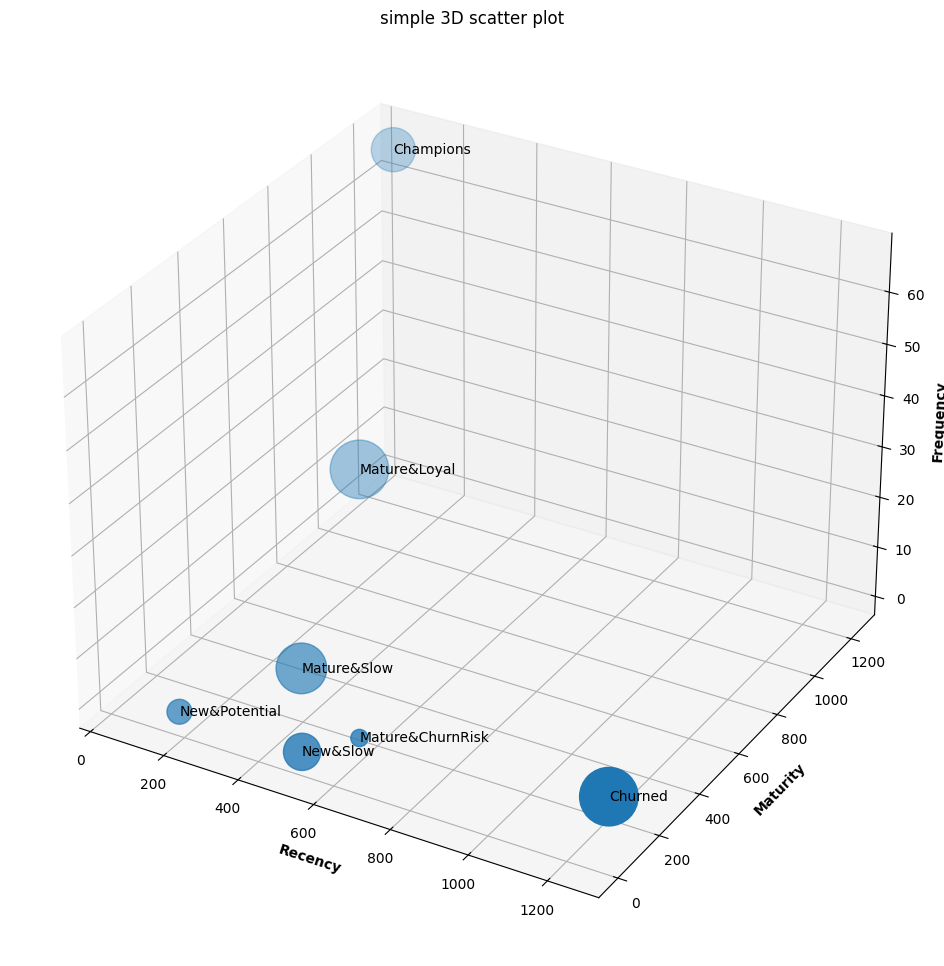

In [3]:
q=('''
   
   SELECT created as order_date, order_id as order_iD, order_amount as order_amount, user_id as user_id
FROM public.sales_userorderdata
WHERE
order_status='Delivered';

''')


e=pd.read_sql(q,conn)
# e = e[e['order_date'] >= '2023-01-01']
# e = e[e['order_date'] <= '2023-06-30']
e['order_date']=e['order_date'].dt.date
e['order_date']=pd.to_datetime(e['order_date'])
e['user_id']=e['user_id']
e['order_amount']=e['order_amount']



#Delta Columns
e['DeltaDaysinOrders']=(e.groupby('user_id').order_date.shift() - e.order_date).dt.days.abs()
e['DeltaOrderValues']=(e.groupby('user_id').order_amount.shift() - e.order_amount)

x1=e.groupby('user_id').agg(
        LastDate=pd.NamedAgg(column='order_date', aggfunc= 'max'),
        FirstDate=pd.NamedAgg(column='order_date', aggfunc='min'),
        Frequency=pd.NamedAgg(column='order_id', aggfunc='count'),
        AOV=pd.NamedAgg(column='order_amount', aggfunc='sum'),
        MeanDaysDelta=pd.NamedAgg(column='DeltaDaysinOrders', aggfunc='mean'),
        MeanOVDelta=pd.NamedAgg(column='DeltaOrderValues', aggfunc='mean')

    ).reset_index()


globalmaxdate=e['order_date'].max()
x1['Recency']=globalmaxdate-x1['LastDate']
x1['Recency']=x1['Recency'].dt.days.abs()
x1['ActivatedQuater']=x1['FirstDate'].dt.to_period('Q')
x1['MaturityAge']=x1['LastDate']-x1['FirstDate']
x1['MaturityAge']=x1['MaturityAge'].dt.days.abs()
x1['MeanDaysDelta']=x1['MeanDaysDelta'].fillna(0)
x1['MeanOVDelta']=x1['MeanOVDelta'].fillna(0)
x1['FrequencyperDeltaDays']=x1['Frequency']/x1['MeanDaysDelta']


r_labels, f_labels,AOV_labels, m_labels,DelAOV_labels = range(4, 0, -1), range(1,5), range(1,5),range(1,5),range(1,5)
x1['r_score'] = x1['Recency'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = r_labels)).astype('int64')
x1['f2d_score'] = x1['Frequency'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = f_labels)).astype('int64')
x1['AOV_score'] = x1['AOV'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = AOV_labels)).astype('int64')
x1['m_score'] = x1['MaturityAge'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = m_labels)).astype('int64')
x1['DelAOV'] = x1['MeanOVDelta'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = DelAOV_labels)).astype('int64')
x1['SumScore'] = x1['r_score'] + x1['f2d_score'] + x1['m_score'] + x1['AOV_score']+ x1['DelAOV']

def CohortLables(df):
    if df['SumScore'] >= 18:
        return 'Champions'
    elif ((df['m_score'] <=1) and (df['SumScore'] >= 10)and (df['SumScore'] < 18) and (df['r_score'] >1)):
        return 'New&Potential'
    elif ((df['m_score'] >1) and (df['SumScore'] >= 14)and (df['SumScore'] < 18)and (df['r_score'] >1)):
        return 'Mature&Loyal'
    elif ((df['m_score'] >1) and (df['SumScore'] >= 10)and (df['SumScore'] < 14)and (df['r_score'] >1)):
        return 'Mature&Slow'
   
    elif ((df['m_score'] <=1) and (df['SumScore'] >= 5)and (df['SumScore'] < 10)and (df['r_score'] >1)):
        return 'New&Slow'
    elif ((df['m_score'] >1) and (df['SumScore'] >= 5)and (df['SumScore'] < 10)and (df['r_score'] >1)):
        return 'Mature&ChurnRisk'
    else:
        return 'Churned'
# Create a new variable RFM_Level
x1['CohortLabel'] = x1.apply(CohortLables, axis=1)



segstats=x1.groupby(
   'CohortLabel'
).agg(
       Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),  
       Recency=pd.NamedAgg(column='Recency', aggfunc='mean'),
       Frequency=pd.NamedAgg(column='Frequency', aggfunc='mean'),
       AOV=pd.NamedAgg(column='AOV', aggfunc='mean'),
       MeanDaysDelta=pd.NamedAgg(column='MeanDaysDelta', aggfunc='mean'),
       MeanOVDelta=pd.NamedAgg(column='MeanOVDelta', aggfunc='mean'),
      FrequencyperDeltaDays=pd.NamedAgg(column='FrequencyperDeltaDays', aggfunc='mean'),
    Maturity=pd.NamedAgg(column='MaturityAge', aggfunc='mean')
   
 ).reset_index()

segstats['OrderCountMix']=segstats['Frequency']/segstats['Frequency'].sum()
segstats['UsersMix']=segstats['Users']/segstats['Users'].sum()


#Visualization of cohorts with key parameters as axises
fig = plt.figure(figsize = (25, 12))
ax = plt.axes(projection ="3d")
size=segstats['Users']*.25
# Creating plot
ax.scatter3D(segstats['Recency'], segstats['Maturity'],segstats['Frequency'], s=size)
plt.title("simple 3D scatter plot")
ax.set_xlabel('Recency', fontweight ='bold')
ax.set_ylabel('Maturity', fontweight ='bold')
ax.set_zlabel('Frequency', fontweight ='bold')
for i in range(len(segstats)):
     ax.text(segstats['Recency'][i],
               segstats['Maturity'][i],
             segstats['Frequency'][i],
               segstats['CohortLabel'][i],
               horizontalalignment='left',
               rotation=25, wrap=True,
               verticalalignment='center',
               size='medium', color='black')
     
   
   
##traxn level insights Trxn Dist by Acquisition months
e2=e.merge(x1[['user_id','MeanDaysDelta','MeanOVDelta','LastDate','FirstDate']], left_on='user_id', right_on='user_id')
e2['AcqMonth']=e2['FirstDate'].dt.strftime('%Y-%m')
e2['OrderMonth']=e2['order_date'].dt.strftime('%Y-%m')

x2=e2.groupby(
   ['AcqMonth','OrderMonth']
).agg(
       Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),  
        ).unstack()

x2=x2.reset_index()

In [4]:
e2

,order_date,order_id,order_amount,user_id,DeltaDaysinOrders,DeltaOrderValues,MeanDaysDelta,MeanOVDelta,LastDate,FirstDate,AcqMonth,OrderMonth
0,2023-05-17,NGPSANQ47647,2996.0,28044,NaN,NaN,182.771429,-4.990476,2023-09-02,2020-05-05,2020-05,2023-05
1,2023-05-11,NGPSA6S47424,851.0,28044,6.0,2145.0,182.771429,-4.990476,2023-09-02,2020-05-05,2020-05,2023-05
2,2023-06-15,NGPSA3H48751,824.0,28044,35.0,27.0,182.771429,-4.990476,2023-09-02,2020-05-05,2020-05,2023-06
3,2023-07-05,NGPSA7449488,4009.0,28044,20.0,-3185.0,182.771429,-4.990476,2023-09-02,2020-05-05,2020-05,2023-07
4,2023-07-15,NGPSAY049982,1270.0,28044,10.0,2739.0,182.771429,-4.990476,2023-09-02,2020-05-05,2020-05,2023-07
...,...,...,...,...,...,...,...,...,...,...,...,...
502834,2023-05-07,BSPSAD027896,2749.0,56494,NaN,NaN,0.000000,0.000000,2023-05-07,2023-05-07,2023-05,2023-05
502835,2023-05-13,RPRSAFQ05937,2295.0,56760,NaN,NaN,0.000000,0.000000,2023-05-13,2023-05-13,2023-05,2023-05
502836,2023-05-17,RPRSAHX06951,1019.0,51584,NaN,NaN,0.000000,0.000000,2023-05-17,2023-05-17,2023-05,2023-05
502837,2023-05-12,RPRSAOQ05605,2436.0,53727,NaN,NaN,0.000000,0.000000,2023-05-12,2023-05-12,2023-05,2023-05


# Repurchase Chart

In [5]:
repurchase_table = e2.groupby([
   'AcqMonth', 'OrderMonth']
).agg(
       Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
 ).unstack()

repurchase_table.columns = repurchase_table.columns.droplevel(0)

repurchase_table = repurchase_table.fillna(0)
repurchase_table = repurchase_table.astype(int)

In [6]:
repurchase_table

OrderMonth,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,...,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09
AcqMonth,,,,,,,,,,,,,,,,,,,,,
2019-04,2828,1984,1859,1864,1800,1718,1653,1594,1556,1540,...,806,779,756,749,726,702,672,707,709,362
2019-05,0,1162,573,565,530,494,491,491,454,438,...,235,223,211,214,216,216,190,216,208,122
2019-06,0,0,807,390,354,322,317,299,255,283,...,143,139,141,150,130,128,121,126,121,60
2019-07,0,0,0,777,356,311,304,310,252,257,...,133,129,133,129,133,128,120,131,124,50
2019-08,0,0,0,0,724,334,295,277,250,244,...,136,139,127,139,115,126,114,124,117,64
2019-09,0,0,0,0,0,763,357,320,302,275,...,119,125,125,136,124,123,115,136,123,63
2019-10,0,0,0,0,0,0,657,296,248,206,...,112,112,99,104,109,103,113,101,102,50
2019-11,0,0,0,0,0,0,0,603,241,232,...,105,98,89,87,92,90,78,83,82,41
2019-12,0,0,0,0,0,0,0,0,520,226,...,81,79,70,75,76,82,68,71,68,33


In [7]:
def divide_non_zero(row):
    first_non_zero = None
    for i in range(len(row)):
        if row.iloc[i] != 0:
            if first_non_zero is None:
                first_non_zero = row.iloc[i]
            else:
                row.iloc[i] = row.iloc[i] * 100 / first_non_zero
    return row

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    repurchase_table_ratio = repurchase_table.apply(divide_non_zero, axis=1)
repurchase_table_ratio = repurchase_table_ratio.round(2)

In [8]:
for i in range(1, len(repurchase_table_ratio)):
    repurchase_table_ratio.iloc[i, :i] = "-"
for i in range(1, len(repurchase_table)):
    repurchase_table.iloc[i, :i] = "-"
# repurchase_table_ratio.iloc[i, i] =   # round(repurchase_table_ratio.iloc[i, i], -1)  # int(repurchase_table_ratio.iloc[i, i])   # int(str(repurchase_table_ratio.iloc[i, i])[:-2])

C:\Users\CEPL\AppData\Local\Temp\ipykernel_6436\2059624869.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  repurchase_table_ratio.iloc[i, :i] = "-"
C:\Users\CEPL\AppData\Local\Temp\ipykernel_6436\2059624869.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  repurchase_table.iloc[i, :i] = "-"


In [9]:
repurchase_table_ratio

OrderMonth,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,...,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09
AcqMonth,,,,,,,,,,,,,,,,,,,,,
2019-04,2828.0,70.16,65.74,65.91,63.65,60.75,58.45,56.36,55.02,54.46,...,28.5,27.55,26.73,26.49,25.67,24.82,23.76,25.0,25.07,12.80
2019-05,-,1162.0,49.31,48.62,45.61,42.51,42.25,42.25,39.07,37.69,...,20.22,19.19,18.16,18.42,18.59,18.59,16.35,18.59,17.9,10.50
2019-06,-,-,807.0,48.33,43.87,39.9,39.28,37.05,31.6,35.07,...,17.72,17.22,17.47,18.59,16.11,15.86,14.99,15.61,14.99,7.43
2019-07,-,-,-,777.0,45.82,40.03,39.12,39.9,32.43,33.08,...,17.12,16.6,17.12,16.6,17.12,16.47,15.44,16.86,15.96,6.44
2019-08,-,-,-,-,724.0,46.13,40.75,38.26,34.53,33.7,...,18.78,19.2,17.54,19.2,15.88,17.4,15.75,17.13,16.16,8.84
2019-09,-,-,-,-,-,763.0,46.79,41.94,39.58,36.04,...,15.6,16.38,16.38,17.82,16.25,16.12,15.07,17.82,16.12,8.26
2019-10,-,-,-,-,-,-,657.0,45.05,37.75,31.35,...,17.05,17.05,15.07,15.83,16.59,15.68,17.2,15.37,15.53,7.61
2019-11,-,-,-,-,-,-,-,603.0,39.97,38.47,...,17.41,16.25,14.76,14.43,15.26,14.93,12.94,13.76,13.6,6.80
2019-12,-,-,-,-,-,-,-,-,520.0,43.46,...,15.58,15.19,13.46,14.42,14.62,15.77,13.08,13.65,13.08,6.35


In [10]:
repurchase_table_ratio_to_show = pd.DataFrame(index=repurchase_table_ratio.index)

def get_diagonal_elements(df, col_num):
    diagonal_elements = [df.iloc[i, col_num + i] for i in range(min(df.shape[0], df.shape[1] - col_num))]
    return diagonal_elements

diagonals = []
for i in range (0, len(repurchase_table_ratio)-1):
    x = get_diagonal_elements(repurchase_table_ratio, i)
    diagonals.append(x)

padded_diagonals = [l + [np.nan] * (54- len(l)) for l in diagonals]

for i in range (len(padded_diagonals)):
    repurchase_table_ratio_to_show[i] = padded_diagonals[i]
x = repurchase_table_ratio_to_show.columns.tolist()
x[0] = "Customer Count"
repurchase_table_ratio_to_show.columns = x
repurchase_table_ratio_to_show.columns.name = "Repurchase_Month_Index"
repurchase_table_ratio_to_show

Repurchase_Month_Index,Customer Count,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
AcqMonth,,,,,,,,,,,,,,,,,,,,,
2019-04,2828.0,70.16,65.74,65.91,63.65,60.75,58.45,56.36,55.02,54.46,...,28.47,28.50,27.55,26.73,26.49,25.67,24.82,23.76,25.00,25.07
2019-05,1162.0,49.31,48.62,45.61,42.51,42.25,42.25,39.07,37.69,36.83,...,20.22,19.19,18.16,18.42,18.59,18.59,16.35,18.59,17.90,10.50
2019-06,807.0,48.33,43.87,39.90,39.28,37.05,31.60,35.07,32.96,32.96,...,17.22,17.47,18.59,16.11,15.86,14.99,15.61,14.99,7.43,NaN
2019-07,777.0,45.82,40.03,39.12,39.90,32.43,33.08,29.86,32.18,29.34,...,17.12,16.60,17.12,16.47,15.44,16.86,15.96,6.44,NaN,NaN
2019-08,724.0,46.13,40.75,38.26,34.53,33.70,31.22,32.87,28.18,28.87,...,19.20,15.88,17.40,15.75,17.13,16.16,8.84,NaN,NaN,NaN
2019-09,763.0,46.79,41.94,39.58,36.04,34.21,35.12,31.32,31.06,31.19,...,16.25,16.12,15.07,17.82,16.12,8.26,NaN,NaN,NaN,NaN
2019-10,657.0,45.05,37.75,31.35,32.57,34.55,26.33,27.55,27.25,26.94,...,15.68,17.20,15.37,15.53,7.61,NaN,NaN,NaN,NaN,NaN
2019-11,603.0,39.97,38.47,32.84,34.16,24.71,27.69,29.02,28.36,24.88,...,12.94,13.76,13.60,6.80,NaN,NaN,NaN,NaN,NaN,NaN
2019-12,520.0,43.46,42.69,36.35,29.62,27.88,28.85,26.35,26.73,27.31,...,13.65,13.08,6.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
mean_lst

[40.20905660377359,
 34.153269230769226,
 30.662549019607848,
 28.857200000000002,
 27.585510204081633,
 26.793541666666666,
 25.9931914893617,
 25.789130434782614,
 25.22155555555555,
 24.687500000000004]

In [13]:
mean_lst_diff

[-17.731208488669683,
 -11.3843118813415,
 -6.256147580527028,
 -4.609991936020842,
 -2.9558187837490686,
 -3.0790762174492055,
 -0.7912676819217679,
 -2.2503563587775757,
 -2.1632630098452528]

In [18]:
mean_lst = []
for i in range (1, 11):
    dummy = (repurchase_table_ratio_to_show.iloc[:-i, i]).mean()
    # print(repurchase_table_ratio_to_show.iloc[:-i, i])
    mean_lst.append(dummy)
mean_lst_diff = []
for i in range (1, len(mean_lst)):
    mean_lst_diff.append(((mean_lst[i] - mean_lst[i-1]) * 100) / mean_lst[i])
    
for i in range (len(mean_lst_diff)):
    if abs(mean_lst_diff[i]) < 11:
        monthdiff = f"{i+1}th Month, {round(mean_lst[i], 2)}%"
        str = f"Month on Month retentionkeeps dropping till {i+1}th Month where it starts to stablize on an average of {round(mean_lst[i], 2)}%"
        break
str

'Month on Month retentionkeeps dropping till 3th Month where it starts to stablize on an average of 30.66%'

In [43]:
repurchase_table_to_show = pd.DataFrame(index=repurchase_table.index)

def get_diagonal_elements(df, col_num):
    diagonal_elements = [df.iloc[i, col_num + i] for i in range(min(df.shape[0], df.shape[1] - col_num))]
    return diagonal_elements

diagonals = []
for i in range (0, len(repurchase_table)-1):
    x = get_diagonal_elements(repurchase_table, i)
    diagonals.append(x)

padded_diagonals = [l + [np.nan] * (54- len(l)) for l in diagonals]

for i in range (len(padded_diagonals)):
    repurchase_table_to_show[i] = padded_diagonals[i]
x = repurchase_table_to_show.columns.tolist()
x[0] = "Customer Count"
repurchase_table_to_show.columns = x
repurchase_table_to_show.columns.name = "Repurchase_Month_Index"
repurchase_table_to_show

Repurchase_Month_Index,Customer Count,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
AcqMonth,,,,,,,,,,,,,,,,,,,,,
2019-04,2828,1984.0,1859.0,1864.0,1800.0,1718.0,1653.0,1594.0,1556.0,1540.0,...,805.0,806.0,779.0,756.0,749.0,726.0,702.0,672.0,707.0,709.0
2019-05,1162,573.0,565.0,530.0,494.0,491.0,491.0,454.0,438.0,428.0,...,235.0,223.0,211.0,214.0,216.0,216.0,190.0,216.0,208.0,122.0
2019-06,807,390.0,354.0,322.0,317.0,299.0,255.0,283.0,266.0,266.0,...,139.0,141.0,150.0,130.0,128.0,121.0,126.0,121.0,60.0,NaN
2019-07,777,356.0,311.0,304.0,310.0,252.0,257.0,232.0,250.0,228.0,...,133.0,129.0,133.0,128.0,120.0,131.0,124.0,50.0,NaN,NaN
2019-08,724,334.0,295.0,277.0,250.0,244.0,226.0,238.0,204.0,209.0,...,139.0,115.0,126.0,114.0,124.0,117.0,64.0,NaN,NaN,NaN
2019-09,763,357.0,320.0,302.0,275.0,261.0,268.0,239.0,237.0,238.0,...,124.0,123.0,115.0,136.0,123.0,63.0,NaN,NaN,NaN,NaN
2019-10,657,296.0,248.0,206.0,214.0,227.0,173.0,181.0,179.0,177.0,...,103.0,113.0,101.0,102.0,50.0,NaN,NaN,NaN,NaN,NaN
2019-11,603,241.0,232.0,198.0,206.0,149.0,167.0,175.0,171.0,150.0,...,78.0,83.0,82.0,41.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-12,520,226.0,222.0,189.0,154.0,145.0,150.0,137.0,139.0,142.0,...,71.0,68.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
idx1 = repurchase_table_to_show.index.get_loc("2023-01")
idx2 = repurchase_table_to_show.index.get_loc("2023-07")
# idx3 = repurchase_table_to_show.columns.get_loc("2023-01")
# idx4 = repurchase_table_to_show.columns.get_loc("2023-07")
row_month = repurchase_table_to_show[idx1:idx2]
nan_index = row_month.isna().idxmax(axis=1)[0]
row_month = row_month.iloc[:, :nan_index]
# row_month.columns = pd.to_datetime(row_month.columns).strftime('%Y-%b')
row_month.index = pd.to_datetime(row_month.index).strftime('%Y-%b')
row_month

C:\Users\CEPL\AppData\Local\Temp\ipykernel_17252\3310599072.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nan_index = row_month.isna().idxmax(axis=1)[0]


Repurchase_Month_Index,Customer Count,1,2,3,4,5,6,7,8
AcqMonth,,,,,,,,,
2023-Jan,374,107.0,95.0,70.0,61.0,54.0,58.0,46.0,26.0
2023-Feb,433,132.0,84.0,64.0,53.0,44.0,49.0,20.0,NaN
2023-Mar,446,143.0,95.0,74.0,59.0,61.0,27.0,NaN,NaN
2023-Apr,452,150.0,86.0,65.0,65.0,30.0,NaN,NaN,NaN
2023-May,464,138.0,97.0,79.0,26.0,NaN,NaN,NaN,NaN
2023-Jun,414,140.0,79.0,39.0,NaN,NaN,NaN,NaN,NaN


In [51]:
# # (repurchase_table_ratio.tail(12)).iloc[:, -12:]
# idx1 = repurchase_table_ratio.index.get_loc("2023-01")
# idx2 = repurchase_table_ratio.index.get_loc("2023-07")
# idx3 = repurchase_table_ratio.columns.get_loc("2023-01")
# idx4 = repurchase_table.columns.get_loc("2023-07")
# row_month_ratio = repurchase_table_ratio[idx1:idx2]
# row_month_ratio = row_month_ratio.iloc[:, idx3:idx4]
# row_month_ratio.columns = pd.to_datetime(row_month_ratio.columns).strftime('%Y-%b')
# row_month_ratio.index = pd.to_datetime(row_month_ratio.index).strftime('%Y-%b')
# row_month_ratio

In [56]:
idx1 = repurchase_table_ratio_to_show.index.get_loc("2023-01")
idx2 = repurchase_table_ratio_to_show.index.get_loc("2023-07")
# idx3 = repurchase_table_to_show.columns.get_loc("2023-01")
# idx4 = repurchase_table_to_show.columns.get_loc("2023-07")
row_month = repurchase_table_ratio_to_show[idx1:idx2]
nan_index = row_month.isna().idxmax(axis=1)[0]
row_month = row_month.iloc[:, :nan_index]
# row_month.columns = pd.to_datetime(row_month.columns).strftime('%Y-%b')
row_month.index = pd.to_datetime(row_month.index).strftime('%Y-%b')
for i in range(1, len(row_month)):
        row_month.iloc[i, -i:] = "-"
row_month

C:\Users\CEPL\AppData\Local\Temp\ipykernel_17252\3444713977.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nan_index = row_month.isna().idxmax(axis=1)[0]
C:\Users\CEPL\AppData\Local\Temp\ipykernel_17252\3444713977.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  row_month.iloc[i, -i:] = "-"


Repurchase_Month_Index,Customer Count,1,2,3,4,5,6,7,8
AcqMonth,,,,,,,,,
2023-Jan,374.0,28.61,25.40,18.72,16.31,14.44,15.51,12.3,6.95
2023-Feb,433.0,30.48,19.40,14.78,12.24,10.16,11.32,4.62,-
2023-Mar,446.0,32.06,21.30,16.59,13.23,13.68,6.05,-,-
2023-Apr,452.0,33.19,19.03,14.38,14.38,6.64,-,-,-
2023-May,464.0,29.74,20.91,17.03,5.6,-,-,-,-
2023-Jun,414.0,33.82,19.08,9.42,-,-,-,-,-


C:\Users\CEPL\AppData\Local\Temp\ipykernel_17252\809312223.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nan_index = row_month.isna().idxmax(axis=1)[0]


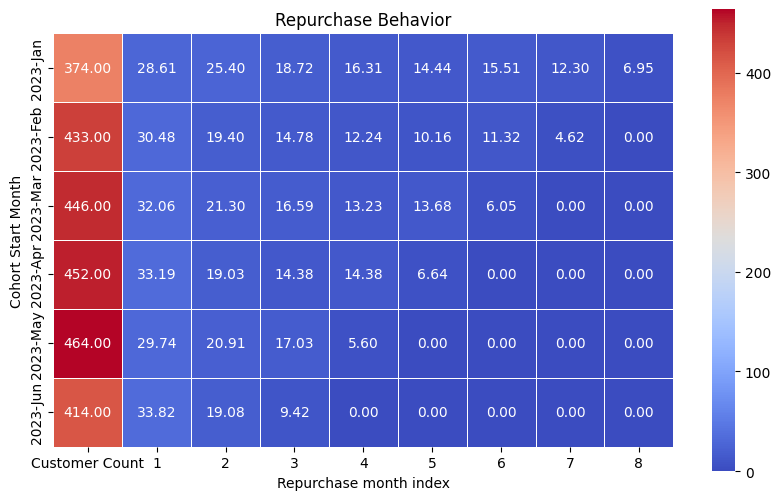

In [58]:
idx1 = repurchase_table_ratio_to_show.index.get_loc("2023-01")
idx2 = repurchase_table_ratio_to_show.index.get_loc("2023-07")
# idx3 = repurchase_table_to_show.columns.get_loc("2023-01")
# idx4 = repurchase_table_to_show.columns.get_loc("2023-07")
row_month = repurchase_table_ratio_to_show[idx1:idx2]
nan_index = row_month.isna().idxmax(axis=1)[0]
row_month = row_month.iloc[:, :nan_index]
# row_month.columns = pd.to_datetime(row_month.columns).strftime('%Y-%b')
row_month.index = pd.to_datetime(row_month.index).strftime('%Y-%b')

plt.figure(figsize=(10, 6))
row_month_ratio = row_month.fillna(0)
sns.heatmap(row_month_ratio, annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5, cbar=True, square=True)

# x_labels = range(0, 12)
# x_positions = range(0, 12)
# plt.xticks(x_positions, x_labels)
# plt.xticks(rotation=0)
plt.title('Repurchase Behavior')
plt.xlabel('Repurchase month index')
plt.ylabel('Cohort Start Month')
plt.show()

In [23]:
# Alert
x = (repurchase_table_ratio.tail(12)).iloc[:, -12:]
diagonal_values = [x.iloc[i, i + 3] for i in range(min(len(x), 9))][-6:]
avg = sum(diagonal_values) / len(diagonal_values)
print("The third month maturity for the last 6 months is ", avg)

The third month maturity for the last 6 months is  15.153333333333334


In [ ]:
# plt.figure(figsize=(10, 6))
# repurchase_table = repurchase_table.fillna(0)
# sns.heatmap((repurchase_table.tail(12)).iloc[:, -12:], annot=True, fmt='d', cmap='coolwarm', linewidths=.5, cbar=True, square=True)

# x_labels = range(0, 12)
# x_positions = range(0, 12)
# plt.xticks(x_positions, x_labels)
# plt.xticks(rotation=0)
# plt.title('Repurchase Behavior')
# plt.xlabel('Repurchase month index')
# plt.ylabel('Cohort Start Month')
# plt.show()

In [ ]:
# plt.figure(figsize=(12, 10))
# repurchase_table = repurchase_table.fillna(0)
# sns.heatmap((repurchase_table_ratio.tail(12)).iloc[:, -12:], annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5, cbar=True, square=True)

# x_labels = range(0, 12)
# x_positions = range(0, 12)
# plt.xticks(x_positions, x_labels)
# plt.xticks(rotation=0)
# plt.yticks(rotation=0)
# plt.title('Repurchase Behavior')
# plt.xlabel('Repurchase month index')
# plt.ylabel('Cohort Start Month')
# plt.show()

# Number of Days Between Transactions

In [24]:
# Date Filter 
# e2=e2[e2['OrderDate']>='2022-01-01']
# e2=e2[e2['OrderDate']<='2022-12-31']
txn_delta_day_count = e2[e2["DeltaDaysinOrders"] > 0]

In [25]:
data = txn_delta_day_count["DeltaDaysinOrders"]
counts, bin_edges = np.histogram(data, bins=100)
histogram_table = pd.DataFrame({'Number of Days Between Successive Purchases': bin_edges[:-1], 'Customer Counts': counts})
histogram_table

,Number of Days Between Successive Purchases,Customer Counts
0,1.00,105474
1,17.18,76407
2,33.36,47931
3,49.54,34242
4,65.72,23008
...,...,...
95,1538.10,47
96,1554.28,25
97,1570.46,24
98,1586.64,26


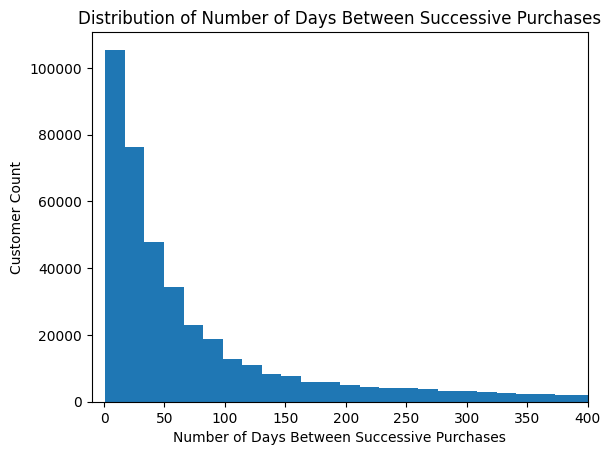

In [26]:
plt.hist(txn_delta_day_count["DeltaDaysinOrders"], bins = 100)
plt.title('Distribution of Number of Days Between Successive Purchases')
plt.ylabel('Customer Count')
plt.xlabel('Number of Days Between Successive Purchases')
plt.xlim(-10, 400)
plt.show()

C:\Users\CEPL\AppData\Local\Temp\ipykernel_9000\3963450420.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(txn_delta_day_count["DeltaDaysinOrders"])


<Axes: xlabel='DeltaDaysinOrders', ylabel='Density'>

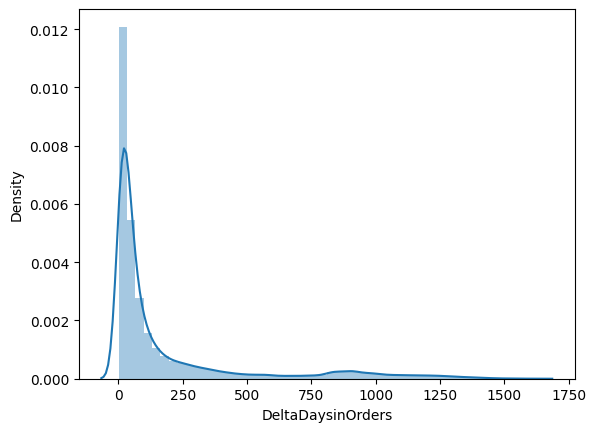

In [27]:
sns.distplot(txn_delta_day_count["DeltaDaysinOrders"])

In [29]:
# txn_delta_day_count['Decile'] = txn_delta_day_count['DeltaDaysinOrders'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [1, 2, 3, 4]))
# txn_delta_day_count['Decile'] = pd.qcut(txn_delta_day_count['DeltaDaysinOrders'].rank(method='first'), q=[0, 0.25, 0.5, 0.75, 1.0], labels=False)

In [30]:
# bins = [0, 15, 50, 100, 500, 1000, float('inf')]

# # Create labels for the bins
# labels = ['Less than 15', '15-50', '50-100', '100-500', '500-1000', 'Greater than 1000']

# # Use pd.cut to bin the 'DeltaDaysinOrders' column
# txn_delta_day_count['DeltaDaysCategory'] = pd.cut(txn_delta_day_count['DeltaDaysinOrders'], bins=bins, labels=labels)

# # Count the number of users in each bin
# user_counts = txn_delta_day_count['DeltaDaysCategory'].value_counts().reindex(labels, fill_value=0)

# # Print the user counts
# print(user_counts)

In [28]:
# Find the minimum and maximum values of 'DeltaDaysinOrders'
min_value = txn_delta_day_count['DeltaDaysinOrders'].min()
max_value = txn_delta_day_count['DeltaDaysinOrders'].max()

# Create 5 equally spaced bins with integral values
bins = pd.cut(txn_delta_day_count['DeltaDaysinOrders'], bins=4, precision=0)

# Get the bin labels
labels = bins.value_counts().sort_index().index.tolist()

# Count the number of users in each bin
user_counts = bins.value_counts().reindex(labels, fill_value=0)

# Print the user counts
print(user_counts)

DeltaDaysinOrders
(-1.0, 406.0]       399845
(406.0, 810.0]       24618
(810.0, 1214.0]      33128
(1214.0, 1619.0]      7556
Name: count, dtype: int64


In [29]:
min_value = txn_delta_day_count['DeltaDaysinOrders'].min()
max_value = txn_delta_day_count['DeltaDaysinOrders'].max()
bins = pd.cut(txn_delta_day_count['DeltaDaysinOrders'], bins=4, precision=0)
labels = bins.value_counts().sort_index().index.tolist()
user_counts = bins.value_counts().reindex(labels, fill_value=0)

bin_df = pd.DataFrame({'Bin Range': labels, 'User Count': user_counts})
bin_df.index.name = 'Bin'
# print(bin_df)

max_range = bin_df[bin_df['User Count'] == bin_df['User Count'].max()]['Bin Range'].values[0]
inner_bins = pd.cut(txn_delta_day_count[txn_delta_day_count['DeltaDaysinOrders'].between(max_range.left, max_range.right, inclusive='both')]['DeltaDaysinOrders'], bins=10, precision=0, include_lowest=True)
inner_labels = inner_bins.value_counts().sort_index().index.tolist()

inner_user_counts = inner_bins.value_counts().reindex(inner_labels, fill_value=0)
inner_bin_df = pd.DataFrame({'Inner Bin Range': inner_labels, 'User Count': inner_user_counts})
inner_bin_df.index.name = 'Inner Bin'
inner_bin_df.drop(columns = ["Inner Bin Range"], inplace = True)
inner_bin_df

,User Count
Inner Bin,
"(0.0, 42.0]",208885
"(42.0, 82.0]",79315
"(82.0, 122.0]",36280
"(122.0, 163.0]",21713
"(163.0, 204.0]",14012
"(204.0, 244.0]",11322
"(244.0, 284.0]",9352
"(284.0, 325.0]",7717
"(325.0, 366.0]",6271


In [30]:
min_value = txn_delta_day_count['DeltaDaysinOrders'].min()
max_value = txn_delta_day_count['DeltaDaysinOrders'].max()

bins = pd.cut(txn_delta_day_count['DeltaDaysinOrders'], bins=4, precision=0)
labels = bins.value_counts().sort_index().index.tolist()
user_counts = bins.value_counts().reindex(labels, fill_value=0)

bin_df = pd.DataFrame({'Days Gap Between Transactions (Lower Limit)': [label.left for label in labels],
                       'Days Gap Between Transactions (Upper Limit)': [label.right for label in labels],
                       'Returned Customer Count': user_counts})

max_range = bin_df[bin_df['Returned Customer Count'] == bin_df['Returned Customer Count'].max()]
inner_bins = pd.cut(txn_delta_day_count[txn_delta_day_count['DeltaDaysinOrders'].between(max_range.iloc[0]['Days Gap Between Transactions (Lower Limit)'], max_range.iloc[0]['Days Gap Between Transactions (Upper Limit)'], inclusive='both')]['DeltaDaysinOrders'], bins=10, precision=0, include_lowest=True)
inner_labels = inner_bins.value_counts().sort_index().index.tolist()
inner_user_counts = inner_bins.value_counts().reindex(inner_labels, fill_value=0)

inner_bin_df = pd.DataFrame({'Days Gap Between Transactions (Lower Limit)': [label.left for label in inner_labels],
                            'Days Gap Between Transactions (Upper Limit)': [label.right for label in inner_labels],
                            'Returned Customer Count': inner_user_counts})

bin_df = bin_df[bin_df['Returned Customer Count'] != bin_df['Returned Customer Count'].max()]
bin_df = pd.concat([bin_df, inner_bin_df], ignore_index=True)
bin_df = bin_df.sort_values(by='Days Gap Between Transactions (Lower Limit)')
bin_df["No of Days Gap Between Transactions"] = bin_df[["Days Gap Between Transactions (Lower Limit)", "Days Gap Between Transactions (Upper Limit)"]].astype("str").apply("-".join, axis=1)
bin_df = bin_df[["No of Days Gap Between Transactions", "Returned Customer Count"]]
bin_df.T

,3,4,5,6,7,8,9,10,11,12,0,1,2
No of Days Gap Between Transactions,0.0-42.0,42.0-82.0,82.0-122.0,122.0-163.0,163.0-204.0,204.0-244.0,244.0-284.0,284.0-325.0,325.0-366.0,366.0-406.0,406.0-810.0,810.0-1214.0,1214.0-1619.0
Returned Customer Count,208885,79315,36280,21713,14012,11322,9352,7717,6271,5087,24618,33128,7556


In [31]:
dummy = str(bin_df.iloc[0, 0]).split("-")
if len(dummy) > 2:
    bin_df.iloc[0, 0] = f"0.0-{dummy[2]}"
for i in range(len(bin_df)):
    x = str(bin_df.iloc[i, 0])
    a = (x.split("-")[0])[:-2]
    b = (x.split("-")[1])[:-2]
    x = a + " - " + b + " Days"
    bin_df.iloc[i, 0] = x
bin_df.set_index("No of Days Gap Between Transactions", inplace = True)
bin_df.T

No of Days Gap Between Transactions,0 - 42 Days,42 - 82 Days,82 - 122 Days,122 - 163 Days,163 - 204 Days,204 - 244 Days,244 - 284 Days,284 - 325 Days,325 - 366 Days,366 - 406 Days,406 - 810 Days,810 - 1214 Days,1214 - 1619 Days
Returned Customer Count,208885,79315,36280,21713,14012,11322,9352,7717,6271,5087,24618,33128,7556


In [ ]:
# Weekly
# Absolute Count View
# Percentage View

# Retention

In [5]:
new_e = e[e["DeltaDaysinOrders"] > 0]
new_e['OrderMonth']=new_e['order_date'].dt.strftime('%Y-%m')

C:\Users\CEPL\AppData\Local\Temp\ipykernel_12268\1863676509.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_e['OrderMonth']=new_e['order_date'].dt.strftime('%Y-%m')


In [6]:
new_e["No of Days since Last Transaction"] = 0 
new_e.loc[new_e["DeltaDaysinOrders"] <= 15 , "No of Days since Last Transaction"] = "Less than 15"
new_e.loc[(new_e["DeltaDaysinOrders"] > 15) & (new_e["DeltaDaysinOrders"] <= 30) , "No of Days since Last Transaction"] = "15 - 30"
new_e.loc[(new_e["DeltaDaysinOrders"] > 30) & (new_e["DeltaDaysinOrders"] <= 60) , "No of Days since Last Transaction"] = "30 - 60"
new_e.loc[(new_e["DeltaDaysinOrders"] > 60) & (new_e["DeltaDaysinOrders"] <= 90) , "No of Days since Last Transaction"] = "60 - 90"
new_e.loc[(new_e["DeltaDaysinOrders"] > 90) & (new_e["DeltaDaysinOrders"] <= 120) , "No of Days since Last Transaction"] = "90 - 120"
new_e.loc[(new_e["DeltaDaysinOrders"] > 120) , "No of Days since Last Transaction"] = "Greater than 120"

C:\Users\CEPL\AppData\Local\Temp\ipykernel_12268\489298127.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_e["No of Days since Last Transaction"] = 0
C:\Users\CEPL\AppData\Local\Temp\ipykernel_12268\489298127.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Less than 15' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_e.loc[new_e["DeltaDaysinOrders"] <= 15 , "No of Days since Last Transaction"] = "Less than 15"


In [7]:
final = new_e.groupby([
   'OrderMonth', 'No of Days since Last Transaction']
).agg(
       Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
 ).unstack()


final.columns = final.columns.droplevel(0)
final["Order_Counts"] = final.values.sum(axis = 1)
final = final[["Order_Counts", "Less than 15", "15 - 30", "30 - 60", "60 - 90", "90 - 120", "Greater than 120"]]

In [8]:
final_ratio = final.copy()
columns_to_divide = ["Less than 15", "15 - 30", "30 - 60", "60 - 90", "90 - 120", "Greater than 120"]
final_ratio[columns_to_divide] = final_ratio[columns_to_divide].div(final_ratio["Order_Counts"], axis=0).round(2)

In [9]:
idx1 = final.index.get_loc("2023-01")
idx2 = final.index.get_loc("2023-07")
row_month = final[idx1:idx2]
# row_month.columns = pd.to_datetime(row_month.columns).strftime('%Y-%b')
row_month.index = pd.to_datetime(row_month.index).strftime('%Y-%b')
row_month

# UX Mention values are wrt count

No of Days since Last Transaction,Order_Counts,Less than 15,15 - 30,30 - 60,60 - 90,90 - 120,Greater than 120
OrderMonth,,,,,,,
2023-Jan,7187,1065,1049,1657,720,369,2327
2023-Feb,6969,967,1244,1683,679,279,2117
2023-Mar,7352,1164,1251,1680,695,378,2184
2023-Apr,7035,1130,892,1363,794,321,2535
2023-May,6727,1461,1139,805,475,341,2506
2023-Jun,6138,1336,1507,1286,357,189,1463


In [10]:
# Alert Last 6 Month Average
last_month = final_ratio.tail(1)
last_6_months_average = final_ratio.tail(6).mean().round(3).rename('Last 6 month average')
last_6_months_average = pd.DataFrame(last_6_months_average).T
alert = pd.concat([last_6_months_average, final_ratio.tail(1)])
alert.columns.name = "Month"
alert

Month,Order_Counts,Less than 15,15 - 30,30 - 60,60 - 90,90 - 120,Greater than 120
Last 6 month average,5152.833,0.28,0.242,0.168,0.053,0.028,0.23
2023-09,2026.000,0.39,0.340,0.190,0.010,0.000,0.07


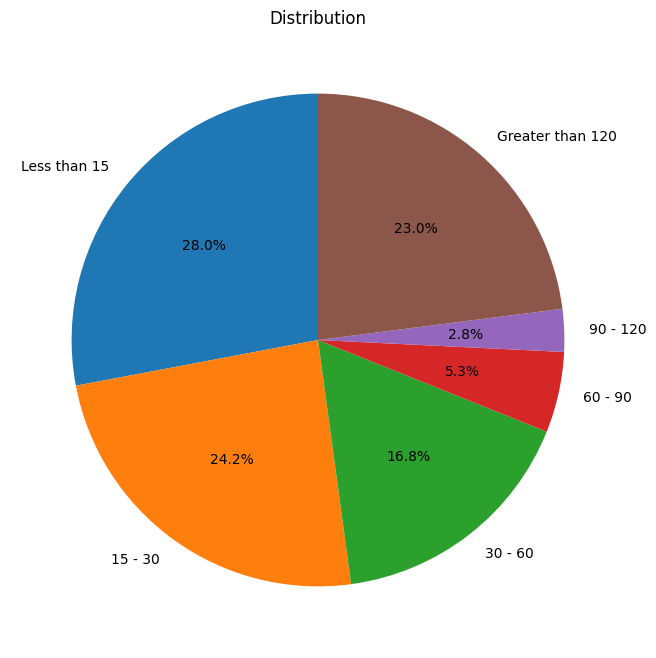

In [11]:
pie_last_6_months_average = last_6_months_average.iloc[:, 1:].iloc[0]
labels = pie_last_6_months_average.index
plt.figure(figsize=(8, 8))
plt.pie(pie_last_6_months_average, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribution')
plt.show()

In [12]:
final_ratio

No of Days since Last Transaction,Order_Counts,Less than 15,15 - 30,30 - 60,60 - 90,90 - 120,Greater than 120
OrderMonth,,,,,,,
2019-04,3450,0.08,0.07,0.09,0.09,0.07,0.59
2019-05,3946,0.09,0.10,0.13,0.08,0.07,0.52
2019-06,4211,0.08,0.09,0.17,0.11,0.07,0.48
2019-07,4873,0.08,0.09,0.14,0.13,0.10,0.46
2019-08,5136,0.08,0.09,0.15,0.13,0.11,0.44
2019-09,5376,0.08,0.09,0.15,0.12,0.11,0.45
2019-10,5575,0.08,0.09,0.14,0.13,0.11,0.44
2019-11,5754,0.07,0.09,0.15,0.12,0.12,0.45
2019-12,5769,0.08,0.09,0.14,0.13,0.11,0.44


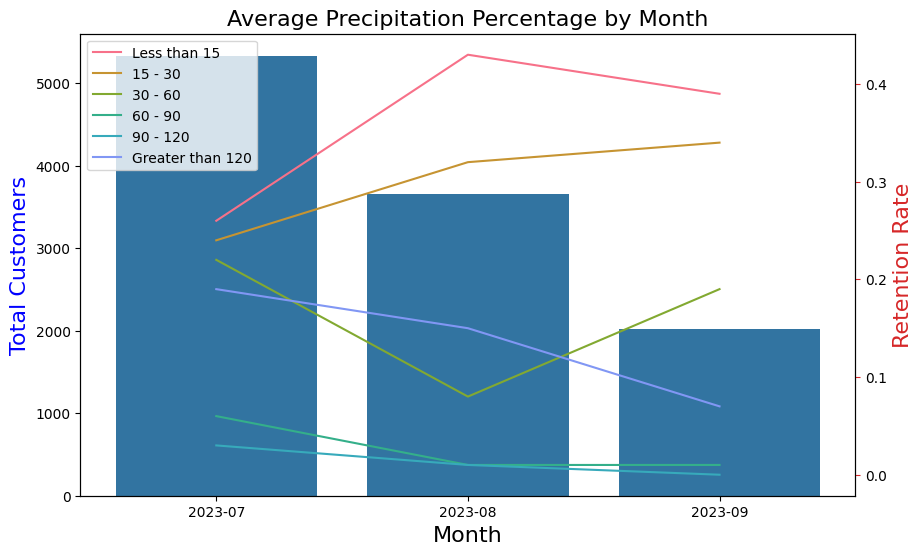

In [13]:
fig, ax1 = plt.subplots(figsize=(10, 6))
color1 = 'blue'
ax1.set_title('Average Precipitation Percentage by Month', fontsize=16)
ax1.set_xlabel('Month', fontsize=16)
ax1.set_ylabel('Total Customers', fontsize=16, color=color1)
ax2 = sns.barplot(x='OrderMonth', y='Order_Counts', data=final_ratio.tail(3))
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Retention Rate', fontsize=16, color=color2)

# Set custom colors for each line
color_palette = sns.color_palette("husl", 7)

sns.lineplot(x='OrderMonth', y="Less than 15", data=final_ratio.tail(3), sort=False, color=color_palette[0], label='Less than 15')
sns.lineplot(x='OrderMonth', y="15 - 30", data=final_ratio.tail(3), sort=False, color=color_palette[1], label='15 - 30')
sns.lineplot(x='OrderMonth', y="30 - 60", data=final_ratio.tail(3), sort=False, color=color_palette[2], label='30 - 60')
sns.lineplot(x='OrderMonth', y="60 - 90", data=final_ratio.tail(3), sort=False, color=color_palette[3], label='60 - 90')
sns.lineplot(x='OrderMonth', y="90 - 120", data=final_ratio.tail(3), sort=False, color=color_palette[4], label='90 - 120')
sns.lineplot(x='OrderMonth', y="Greater than 120", data=final_ratio.tail(3), sort=False, color=color_palette[5], label='Greater than 120')

ax2.tick_params(axis='y', color=color2)

# Add legend
ax2.legend(loc='upper left')

plt.show()

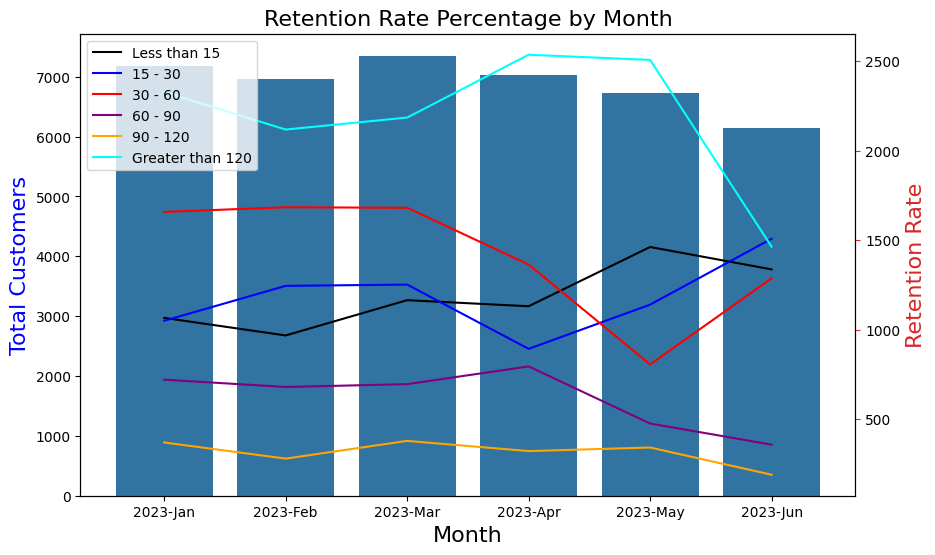

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax1 = plt.subplots(figsize=(10, 6))
color1 = 'blue'
ax1.set_title('Retention Rate Percentage by Month', fontsize=16)
ax1.set_xlabel('Month', fontsize=16)
ax1.set_ylabel('Total Customers', fontsize=16, color=color1)
ax2 = sns.barplot(x='OrderMonth', y='Order_Counts', data=row_month)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Retention Rate', fontsize=16, color=color2)

sns.lineplot(x='OrderMonth', y="Less than 15", data=row_month, sort=False, color='black', label='Less than 15')
sns.lineplot(x='OrderMonth', y="15 - 30", data=row_month, sort=False, color='blue', label='15 - 30')
sns.lineplot(x='OrderMonth', y="30 - 60", data=row_month, sort=False, color='red', label='30 - 60')
sns.lineplot(x='OrderMonth', y="60 - 90", data=row_month, sort=False, color='purple', label='60 - 90')
sns.lineplot(x='OrderMonth', y="90 - 120", data=row_month, sort=False, color='orange', label='90 - 120')
sns.lineplot(x='OrderMonth', y="Greater than 120", data=row_month, sort=False, color='cyan', label='Greater than 120')
ax2.tick_params(axis='y', color=color2)
ax2.legend(loc='upper left')
plt.show()

In [16]:
final

No of Days since Last Transaction,Order_Counts,Less than 15,15 - 30,30 - 60,60 - 90,90 - 120,Greater than 120
OrderMonth,,,,,,,
2019-04,3450,282,246,318,307,257,2040
2019-05,3946,345,404,528,329,276,2064
2019-06,4211,340,385,711,461,274,2040
2019-07,4873,404,434,695,633,477,2230
2019-08,5136,399,476,755,676,549,2281
2019-09,5376,447,458,786,670,606,2409
2019-10,5575,465,503,808,704,621,2474
2019-11,5754,413,523,888,688,671,2571
2019-12,5769,473,529,822,770,640,2535


C:\Users\CEPL\AppData\Local\Temp\ipykernel_12268\2829119376.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '15.832426550598477' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  graph_ratio.iloc[i, j] = graph_ratio.iloc[i, j] * 100 / graph_ratio.iloc[i, 0]
C:\Users\CEPL\AppData\Local\Temp\ipykernel_12268\2829119376.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '17.015778019586506' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  graph_ratio.iloc[i, j] = graph_ratio.iloc[i, j] * 100 / graph_ratio.iloc[i, 0]
C:\Users\CEPL\AppData\Local\Temp\ipykernel_12268\2829119376.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '22.850924918389556' has dtype incompatible with int64, please explicitly

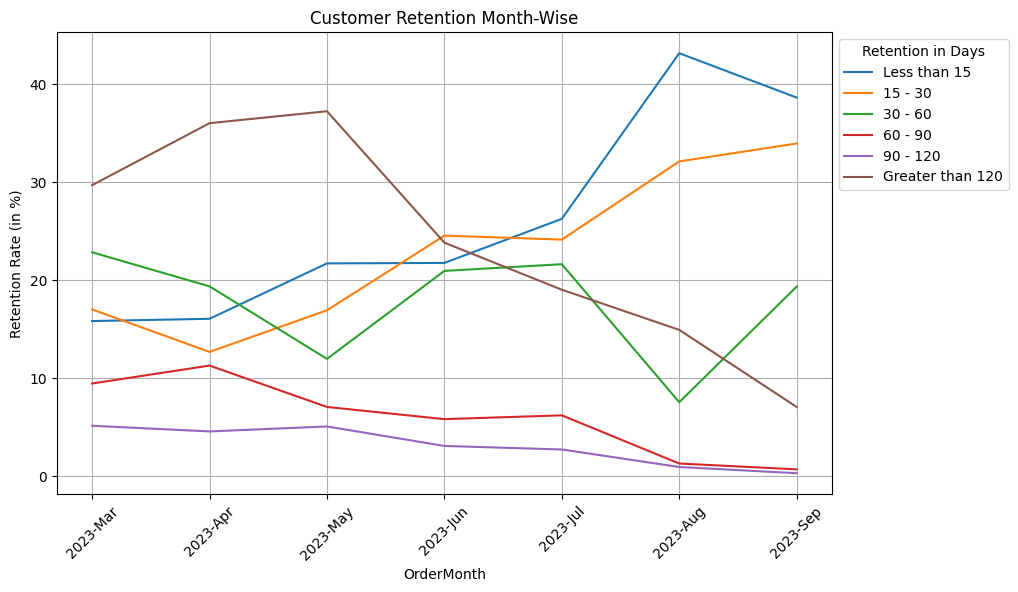

In [25]:
graph = final.copy()
# graph = graph.tail(12)[:-2]
graph = graph.tail(7)
graph_ratio = graph.copy()
for i in range (len(graph_ratio)):
    for j in range (1, len(graph_ratio.T)):
        graph_ratio.iloc[i, j] = graph_ratio.iloc[i, j] * 100 / graph_ratio.iloc[i, 0]

graph_ratio.index = pd.to_datetime(graph_ratio.index).strftime('%Y-%b')
#for insight
graph_ratio = graph_ratio.drop(columns = ["Order_Counts"])

plt.figure(figsize=(10, 6))
for column in graph_ratio.columns:
    plt.plot(graph_ratio.index, graph_ratio[column], label=column)

plt.title('Customer Retention Month-Wise')
plt.xlabel('OrderMonth')
plt.ylabel('Retention Rate (in %)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title = 'Retention in Days')
plt.xticks(rotation=45)
plt.grid(True)

plt.show()

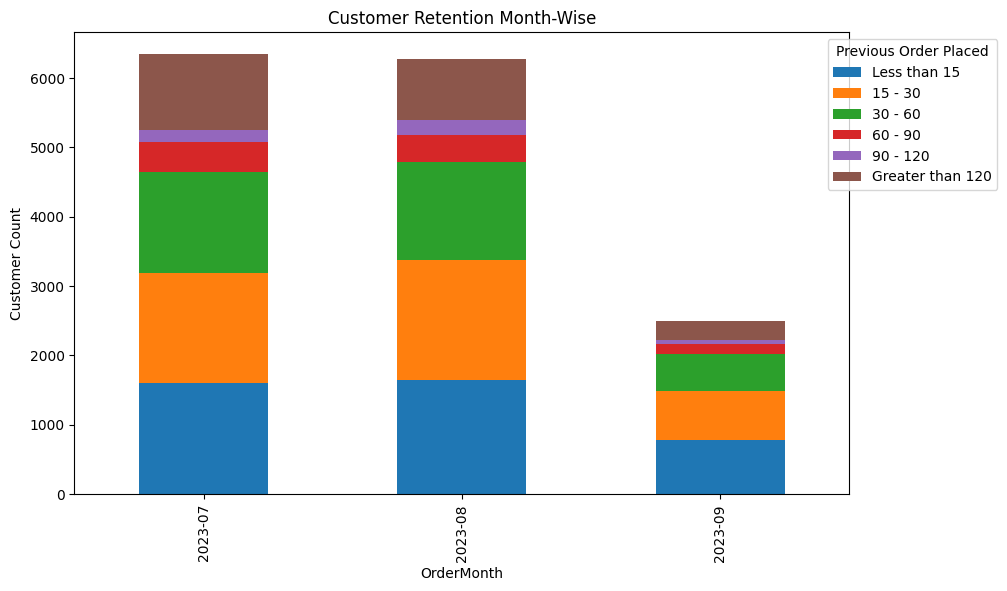

In [45]:
graph2 = final.drop(columns = ["Order_Counts"])
graph2 = graph2.tail(3)#[:-2]
graph2.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Customer Retention Month-Wise')
plt.xlabel('OrderMonth')
plt.ylabel('Customer Count')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1), title = 'Previous Order Placed')
plt.show()

In [ ]:
# Commented Lines

q=('''SELECT x.* FROM public.sales_userorderdata x
ORDER BY x.id,x.user_id 
''')

e=pd.read_sql(q,conn)
print(e.head())

#Diamentions Users, AverageOrderValue, OrderFrequency, Average Delta days in orders, Average Order Value Detla,User Maturity, Rececncy 

# Set Data Columns
e['OderDate']=e['created'].dt.date
e['OderDate']=pd.to_datetime(e['OderDate'])
#Delta Columns
e['DeltaDaysinOrders']=(e.groupby('user_id').OderDate.shift() - e.OderDate).dt.days.abs()
e['DeltaOrderValues']=(e.groupby('user_id').order_amount.shift() - e.order_amount)
#Analysis Parameters 
e=e[e['OderDate']>='2023-01-01']
e=e[e['OderDate']<= '2023-06-30']
e=e[e['order_status']=='Delivered']

x1=e.groupby('user_id').agg(
        LastDate=pd.NamedAgg(column='OderDate', aggfunc= 'max'),
        FirstDate=pd.NamedAgg(column='OderDate', aggfunc='min'),
        Frequency=pd.NamedAgg(column='order_id', aggfunc='nunique'),
        AOV=pd.NamedAgg(column='order_amount', aggfunc='mean'),
        MeanDaysDelta=pd.NamedAgg(column='DeltaDaysinOrders', aggfunc='mean'),
        MeanOVDelta=pd.NamedAgg(column='DeltaOrderValues', aggfunc='mean')

    ).reset_index()


globalmaxdate=e['OderDate'].max()
x1['Recency']=globalmaxdate-x1['LastDate']
x1['Recency']=x1['Recency'].dt.days.abs()
x1['ActivatedQuater']=x1['FirstDate'].dt.to_period('Q')
x1['MaturityAge']=x1['LastDate']-x1['FirstDate']
x1['MaturityAge']=x1['MaturityAge'].dt.days.abs()
x1['MeanDaysDelta']=x1['MeanDaysDelta'].fillna(0)
x1['MeanOVDelta']=x1['MeanOVDelta'].fillna(0)
x1['FrequencyperDeltaDays']=x1['Frequency']/x1['MeanDaysDelta']


r_labels, f2d_labels,AOV_labels, m_labels,DelAOV_labels = range(4, 0, -1), range(1,5), range(1,5),range(1,5),range(1,5)
x1['r_score'] = x1['Recency'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = r_labels)).astype('int64')
x1['f2d_score'] = x1['FrequencyperDeltaDays'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = f2d_labels)).astype('int64')
x1['AOV_score'] = x1['AOV'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = AOV_labels)).astype('int64')
x1['m_score'] = x1['MaturityAge'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = m_labels)).astype('int64')
x1['DelAOV'] = x1['MeanOVDelta'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = DelAOV_labels)).astype('int64')
x1['SumScore'] = x1['r_score'] + x1['f2d_score'] + x1['m_score'] + x1['AOV_score']+ x1['DelAOV']

def CohortLables(df):
    if df['SumScore'] >= 18:
        return 'Champions'
    elif ((df['m_score'] <=1) and (df['SumScore'] >= 10)and (df['SumScore'] < 18) and (df['r_score'] >1)):
        return 'New & Potential'
    elif ((df['m_score'] >1) and (df['SumScore'] >= 14)and (df['SumScore'] < 18)and (df['r_score'] >1)):
        return 'Mature & Loyal'
    elif ((df['m_score'] >1) and (df['SumScore'] >= 10)and (df['SumScore'] < 14)and (df['r_score'] >1)):
        return 'Mature & Slow'
    
    elif ((df['m_score'] <=1) and (df['SumScore'] >= 5)and (df['SumScore'] < 10)and (df['r_score'] >1)):
        return 'New & Slow'
    elif ((df['m_score'] >1) and (df['SumScore'] >= 5)and (df['SumScore'] < 10)and (df['r_score'] >1)):
        return 'Mature & ChurnRisk'
    else:
        return 'Churned'
# Create a new variable RFM_Level
x1['CohortLabel'] = x1.apply(CohortLables, axis=1)

segstats=x1.groupby(
'CohortLabel'
).agg(
    Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),   
    Recency=pd.NamedAgg(column='Recency', aggfunc='mean'), 
    Frequency=pd.NamedAgg(column='Frequency', aggfunc='mean'),
    AOV=pd.NamedAgg(column='AOV', aggfunc='mean'),
    MeanDaysDelta=pd.NamedAgg(column='MeanDaysDelta', aggfunc='mean'),
    MeanOVDelta=pd.NamedAgg(column='MeanOVDelta', aggfunc='mean'),
    FrequencyperDeltaDays=pd.NamedAgg(column='FrequencyperDeltaDays', aggfunc='mean'),
    Maturity=pd.NamedAgg(column='MaturityAge', aggfunc='mean'),
    OrderCount=pd.NamedAgg(column='Frequency', aggfunc='sum'),
    
).reset_index()

segstats['OrderCountMix']=segstats['OrderCount']*100/segstats['OrderCount'].sum()
segstats['UsersMix']=segstats['Users']*100/segstats['Users'].sum()

# print(segstats.columns.tolist())
# save to csv
segstats.to_csv('segstats.csv')

# read from csv
# segstats = pd.read_csv('segstats.csv')


# create a copy of the dataframe
segstats_copy = segstats.copy()

# change the column name
segstats_copy.rename(columns={'CohortLabel':'User Type'}, inplace=True)
segstats_copy.rename(columns={'Users':'User Count'}, inplace=True)
segstats_copy.rename(columns={'Frequency':'Average Order Count'}, inplace=True)
segstats_copy.rename(columns={'AOV':'Average Order Value'}, inplace=True)
segstats_copy.rename(columns={'OrderCount':'Total Order Count Over Time'}, inplace=True)
segstats_copy.rename(columns={'MeanOVDelta':'Average Order Value Difference in Rs'}, inplace=True)
# segstats_copy.rename(columns={'FrequencyperDeltaDays':'Average Gap Between Orders in Days'}, inplace=True)
#  drop a column from the dataframe
segstats_copy.drop(columns=['FrequencyperDeltaDays'], inplace=True)
segstats_copy.rename(columns={'Maturity':'Average Maturity in Days'}, inplace=True)
segstats_copy.rename(columns={'OrderCountMix':'% Order Out Of Total Orders'}, inplace=True)
segstats_copy.rename(columns={'UsersMix':'% Users Out Of Total Users'}, inplace=True)
segstats_copy.rename(columns={'MeanDaysDelta':'Average Gap Between Orders in Days'}, inplace=True)
segstats_copy = segstats_copy.round(0)

# # segstats_copy.to_csv('cohort_'+start_date +'_to_' + end_date +'.csv')
segstats_copy["% Order Out Of Total Orders"] = segstats_copy["% Order Out Of Total Orders"].astype(str) + '%'
segstats_copy["% Users Out Of Total Users"] = segstats_copy["% Users Out Of Total Users"].astype(str) + '%'

